In [278]:
import numpy as np
from ipywidgets import interact, interactive, fixed, interact_manual, FloatSlider,interactive_output
from ipywidgets import HBox, VBox
from scipy.linalg import block_diag
import ipywidgets as widgets
import numba
from scipy.special import expit
import matplotlib
from tqdm import tqdm
import matplotlib.pyplot as plt
from neurolib.utils import functions
%matplotlib inline

## Chaotic properties in coupled oscillator systems

Neural oscillations of the human brain demonstrated emergent collective dynamic with such phenomena like phase synchronization, which is believed  crucial for information processing in the human brain (see links in [@pietrasNetworkDynamicsCoupled2019]. The main question here is how will behave a network of coupled nodes behave collectively given individual node oscillatory dynamics and coupling structure.  Exploring properties of complex networks is an extremely difficult task [@pietrasNetworkDynamicsCoupled2019]. 
 Theoretical investigation of the onset of such emergent dynamic is very complicated because of many degrees of freedom. Even in the most simple case: system with N coupled first ordered "circuit" differential equation [@sompolinskyChaosRandomNeural1988]: 

$\overset{.}{h_i} = -h_i+ \sum_i^jJ_{ij}\phi(h_i)$
where $J_{ii}=0$
Long-time behaviour of this system depends on the particular realisation of matrix $J_{ij}$. In case of symmetric matrix system came to relaxation. When $J_{ij}$ uncorrelated and drawn from Gaussian distribution with zero mean and $g^2/N^2$ variance, where $g$ is gain parameter responsible for coupling strength,  the dynamic of the system is generally non-relaxation but it depends on specific realisation of matrix $J$. Typical behaviour exist only in the limit $N \to \infty$  with chaotic regime corresponds to $g>1$ and zero fixed point when $g<1$. 

[@sternDynamicsRandomNeural2014]  suggested to  use a simple rate-based neural network model with self-interacting units represents cluster of neurons with strong connectivity in the cluster and random weak long-range interactions between clusters :
$\overset{.}{x} = -x_i+s\phi(x_i)+g\sum_{i\neq j}J_{ij}\phi(x_i)$
This is can be considered as a more general case with the separate self-coupling component of previous "circuit" differential equation. In this case dynamics depends on two parameters $s$ and $g$ . Again,  in case of symmetric matrix or matrix with positive or negative elements  system came to the stable state. In the paper [@sternDynamicsRandomNeural2014] the long range activity dynamics investigated over a range of s and g values for the case when $J_{ij}$ drawn from Gaussian distribution with zero mean and $1/N$ standard deviation. They  found interesting interplay between chaos and multiple fixed point for non-zero values g and s.
Additionally we found interesting case when s and g take values from  0.3 to 0.9. For a specific realisation of matrix  $J_{ij}$  we can see all types of dynamics for the same set of parameters: relaxation, limit cycles and transient chaos and chaos.

In [322]:
class SternModel:
    description = "Stern model"
    def __init__(self, s, g, N, act_init=None, seed = None):
        self.s = s
        self.g = g
        Cmat = g*1/np.sqrt(N)*np.random.randn(N,N)
        np.fill_diagonal(Cmat, s)
        self.Cmat = Cmat
        if act_init is None:
            self.act_init = np.random.randn(N)
        else:    
            self.act_init = act_init
        
        self.seed = seed
        
        
    def integrate(self, dt = 1, duration = 2000):      
        
        np.random.seed(self.seed)
        t = np.arange(1, round(duration, 6) / dt + 1) * dt  # Time variable (ms)
        N = np.shape(self.Cmat)[0]
        act = np.zeros((N,len(t)))
        act[:,0] = self.act_init
        
        for i in range(1, len(t)):
            d_act = -act[:,i-1]+self.Cmat@np.tanh(act[:,i-1])
            #d_act = -act[:,i-1]+self.Cmat@expit(act[:,i-1])
            act[:,i] = act[:,i-1]+d_act*dt
        return act    

In [319]:
def draw_s_bifurcation_diagram(s_lim = (-0.5, 2.5), g=1, N=30, node_id=0, axs = None):

    max_act = []
    min_act = []
    # these are the different input values that we want to scan
    s_inputs = np.linspace(s_lim[0], s_lim[1], 50)
    for s in s_inputs:
        sm = SternModel(s, g, N)
        act = sm.integrate(dt=1,duration=2000)
        max_act.append(np.max(act[node_id, -1000:]))
        min_act.append(np.min(act[node_id, -1000:]))
        
    if axs is None:
        fig, axs = plt.subplots(1,1,figsize=(5, 3))
    axs.plot(s_inputs , max_act, c='k', lw = 2)
    axs.plot(s_inputs, min_act, c='r', lw = 2)
    axs.set_title(f"Bifurcation diagram of Stern model g = {g}, N= {N}")
    axs.set_xlabel("Parameter s")
    axs.set_ylabel("Min / max activity")
        

In [320]:
def draw_g_bifurcation_diagram(g_lim = (0, 2.5), s=1, N=30, node_id=0, axs = None):

    max_act = []
    min_act = []
    # these are the different input values that we want to scan
    g_inputs = np.linspace(g_lim[0], g_lim[1], 50)
    for g in g_inputs:
        sm = SternModel(s, g, N)
        act = sm.integrate(dt=1,duration=2000)
        max_act.append(np.max(act[node_id, -1000:]))
        min_act.append(np.min(act[node_id, -1000:]))
        
    if axs is None:
        fig, axs = plt.subplots(1,1,figsize=(5, 3))
    axs.plot(g_inputs , max_act, c='k', lw = 2)
    axs.plot(g_inputs, min_act, c='r', lw = 2)
    axs.set_title(f"Bifurcation diagram of Stern model s={s}, N={N}")
    axs.set_xlabel("Parameter g")
    axs.set_ylabel("Min / max activity")
    plt.show()
    
def plot_bifurcations(g,s,N=30, node_id = 0):
    fig, axs = plt.subplots(1,2,figsize=(12, 4))
    draw_s_bifurcation_diagram(s_lim = (-1, 2.5), node_id=node_id, g=g, N=N, axs=axs[0])
    draw_g_bifurcation_diagram(g_lim = (0, 2.5), s=s, N=N, node_id=node_id, axs = axs[1])

def plot_activity_ph_space(act, node_id, dt=1, delay = 10, drop_first=100, shift=3, title=None):
    fig, axs = plt.subplots(1,3,figsize=(14, 3.5))
    
    axs[0].plot(np.arange(act[node_id,drop_first::shift].shape[0]), act[0:-1:10,drop_first::shift].T)
    axs[0].set_xlabel("Time")
    axs[0].set_ylabel("Activity")
    if title is None:
        axs[0].set_title("Activity dynamics for subset of nodes")
    else:
        axs[0].set_title(title)
    axs[1].scatter(act[node_id,drop_first:-delay:shift], act[node_id,drop_first+delay::shift])  
    axs[1].set_title(f"Phase space diagram for node {node_id}")
    axs[1].set_xlabel("Activity (time)")
    axs[1].set_ylabel("Activity (time - lag)")
    f, Pxx_Welsh = functions.getMeanPowerSpectrum(act, dt=dt)
    axs[2].semilogy(f,  Pxx_Welsh)
    axs[2].set_xlabel('frequency [Hz]')
    axs[2].set_ylabel('PSD [V**2/Hz]')
    axs[2].set_title('Mean Power density for activity'); 
    plt.tight_layout()


In [321]:
N=150
node_id=10
g = widgets.FloatSlider(value = 1, min = 0, max = 2.5, step = 0.25, description = r'g', disabled=False)
s = widgets.FloatSlider(value = 0.7, min = -1, max = 2.5, step = 0.25, description = r's', disabled=False)
row = HBox([g, s])
display(row)
interactive_output(lambda g,s: plot_bifurcations(g,s, N=N, node_id = node_id), {'s':s, 'g': g})


Output()

CPU times: user 1.17 s, sys: 280 ms, total: 1.45 s
Wall time: 306 ms


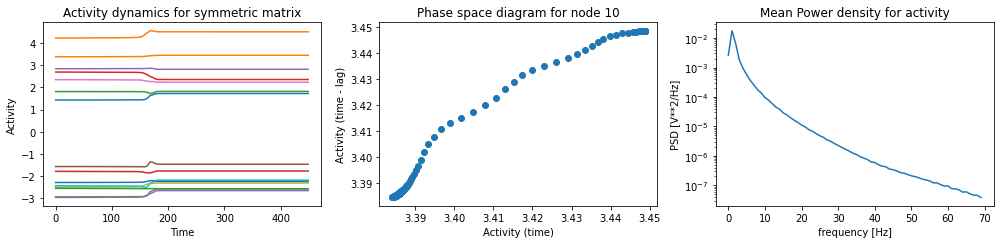

In [224]:
%%time
N=150
g=1.5
s=1
sm = SternModel(s, g, N, act_init=None, seed=None)
sm.Cmat = ((sm.Cmat+sm.Cmat.T)/2)
title = "Activity dynamics for symmetric matrix"
act = sm.integrate(dt=1,duration=1000)
plot_activity_ph_space(act, 10, delay = 10,drop_first=100, shift=2, title=title);

CPU times: user 1.16 s, sys: 338 ms, total: 1.49 s
Wall time: 337 ms


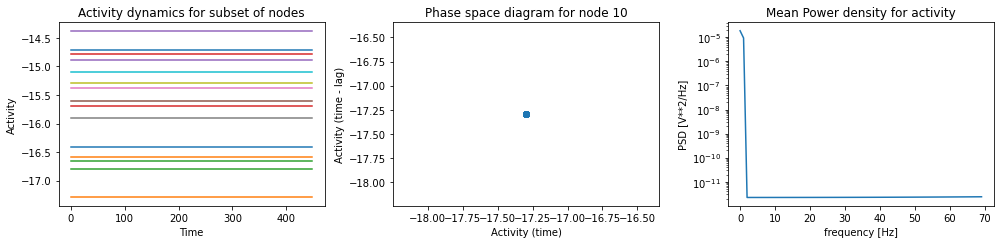

In [225]:
%%time
N=150
g=1.5
s=1
sm = SternModel(s, g, N, act_init=None, seed=None)
sm.Cmat = -1*np.abs(sm.Cmat)
title = "Activity dynamics for negative matrix"

act = sm.integrate(dt=1,duration=1000)
plot_activity_ph_space(act, 10, delay = 10,drop_first=100, shift=2);

In [302]:
%%time
N=30
g=0.45
s=0.5
g = widgets.FloatSlider(value = 0.7, min = 0.2, max = 2, step = 0.05, description = r'g', disabled=False)
s = widgets.FloatSlider(value = 0.5, min = 0, max = 1, step = 0.05, description = r's', disabled=False)
row = HBox([g, s])
display(row)
def draw_activity(s,g):
    sm = SternModel(s, g, N, act_init=None, seed=None)
    act = sm.integrate(dt=1,duration=4000)
    title = f"Activity dynamics for s: {s} and g: {g} "
    plot_activity_ph_space(act, 10, delay = 10, drop_first=100, shift=2, title=title);
interactive_output(draw_activity, {'s':s, 'g': g})

CPU times: user 649 ms, sys: 57.2 ms, total: 706 ms
Wall time: 485 ms


Output()

## Block diagonal matrix

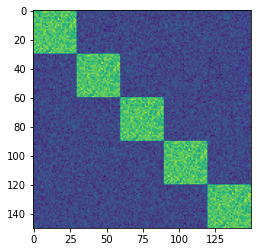

In [314]:
N=150
g=0.7
s=0.5
def create_five_block_mat(N, g,s):
    assert N%5==0, "Number of nodes should divide to 5" 
    Cmat = g*1/np.sqrt(N)*np.random.randn(N,N)
    block_ones = np.ones((N//5,N//5))
    block = s*np.ones((N//5,N//5))+1/np.sqrt(N)*np.random.randn(N//5,N//5)
    inter_conn = Cmat*(1-block_diag(block_ones, block_ones, block_ones,block_ones, block_ones))
    inner_conn = block_diag(block, block, block, block, block)
    J = inter_conn+inner_conn
    return J
plt.imshow(create_five_block_mat(N, g,s))

In [316]:
N=50
g=0.45
s=0.5
g = widgets.FloatSlider(value = 0.7, min = 0.2, max = 2.5, step = 0.05, description = r'g', disabled=False)
s = widgets.FloatSlider(value = 0.15, min = 0, max = 1, step = 0.05, description = r's', disabled=False)
row = HBox([g, s])
display(row)
def draw_activity(s,g):
    sm = SternModel(s, g, N, act_init=None, seed=None)
    sm.Cmat = create_five_block_mat(N, g,s)
    act = sm.integrate(dt=1,duration=4000)
    title = f"Activity dynamics for s: {s} and g: {g} "
    plot_activity_ph_space(act, 10, delay = 10, drop_first=100, shift=2, title=title);
interactive_output(draw_activity, {'s':s, 'g': g})

Output()